# PREDICTING PRIMARY CONTRIBUTORS TO ROAD TRAFFIC CRASHES

## Business Problem

Road Traffic crashes have become a major public safety concern. With a rise in number of crashes in recent times, it is imparative to identify the primary factors contributing to crashes. By doing so, the Department of Road Safety can thereby support targeted interventions, enforcement strategies and improved road infrastructure. 

## Objectives
1. Identify top 10 causes of road accidents in Chicago
2. To determine whether impaired driver conditions are associated with specific contributory causes
3. To investigate how crash frequency and severity differ by presence and type of traffic control devices
4. To identify measures that can be put in place to mitigate road traffic crashes
5. To develop a multiclass classification model that predicts the primary contributory causes of crashes


### Carrying out necessary imports

In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

## Data Loading

In [170]:
crashes = pd.read_csv("data\Traffic_Crashes_-_Crashes.csv.gz")
crashes.head()

,CRASH_RECORD_ID,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,d4532856f89a7311fb6182ffef7cd3c27fdba4dba40671...,NaN,12/30/2025 11:50:00 PM,35,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,SNOW,"DARKNESS, LIGHTED ROAD",ANGLE,FOUR WAY,...,0.0,1.0,1.0,0.0,23,3,12,41.743702,-87.624186,POINT (-87.624185929083 41.743702317364)
1,b938fbfa86d8b2d58d26656bf3266bc5452af63bd100ad...,NaN,12/30/2025 11:21:00 PM,30,UNKNOWN,UNKNOWN,SNOW,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,NOT DIVIDED,...,0.0,0.0,1.0,0.0,23,3,12,41.853734,-87.653792,POINT (-87.653792075361 41.85373399224)
2,bb8c152ed4e0d29961e051b7d381508f1f9ea5aa051dbe...,NaN,12/30/2025 10:55:00 PM,30,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,SIDESWIPE SAME DIRECTION,NOT DIVIDED,...,0.0,0.0,2.0,0.0,22,3,12,41.906573,-87.687268,POINT (-87.687268089375 41.906573215648)
3,40064b1f9d498293c9392d4c89bb60128409738a3c44d1...,NaN,12/30/2025 10:51:00 PM,35,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,SNOW,"DARKNESS, LIGHTED ROAD",ANGLE,FOUR WAY,...,0.0,1.0,3.0,0.0,22,3,12,41.807373,-87.622931,POINT (-87.622930554709 41.807373001937)
4,efce3ab254c9daaacb6ce6a60e10e8cb8ca50ab3f7ea5b...,NaN,12/30/2025 10:43:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,SNOW,"DARKNESS, LIGHTED ROAD",TURNING,DIVIDED - W/MEDIAN (NOT RAISED),...,0.0,0.0,2.0,0.0,22,3,12,41.928409,-87.702567,POINT (-87.702567230162 41.928408615992)


In [171]:
people = pd.read_csv("data\Traffic_Crashes_-_People.csv.gz")
people.head()

c:\Users\This pc\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,PERSON_ID,PERSON_TYPE,CRASH_RECORD_ID,VEHICLE_ID,CRASH_DATE,SEAT_NO,CITY,STATE,ZIPCODE,SEX,...,EMS_RUN_NO,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,PEDPEDAL_ACTION,PEDPEDAL_VISIBILITY,PEDPEDAL_LOCATION,BAC_RESULT,BAC_RESULT VALUE,CELL_PHONE_USE
0,O2218091,DRIVER,d4532856f89a7311fb6182ffef7cd3c27fdba4dba40671...,2114560.0,12/30/2025 11:50:00 PM,NaN,CHICAGO,IL,60617,M,...,NaN,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,O2218092,DRIVER,d4532856f89a7311fb6182ffef7cd3c27fdba4dba40671...,2114556.0,12/30/2025 11:50:00 PM,NaN,NaN,NaN,NaN,X,...,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
2,O2218087,DRIVER,b938fbfa86d8b2d58d26656bf3266bc5452af63bd100ad...,2114554.0,12/30/2025 11:21:00 PM,NaN,NaN,NaN,NaN,X,...,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
3,O2218080,DRIVER,bb8c152ed4e0d29961e051b7d381508f1f9ea5aa051dbe...,2114549.0,12/30/2025 10:55:00 PM,NaN,CHICAGO,IL,60660,M,...,NaN,UNKNOWN,UNKNOWN,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
4,O2218081,DRIVER,bb8c152ed4e0d29961e051b7d381508f1f9ea5aa051dbe...,2114552.0,12/30/2025 10:55:00 PM,NaN,CHICAGO,IL,60618,M,...,NaN,UNKNOWN,UNKNOWN,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN


In [172]:
vehicles = pd.read_csv("data\Traffic_Crashes_-_Vehicles.csv.gz")
vehicles.head()

c:\Users\This pc\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (20,39,40,41,47,48,49,57,58,60) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,CRASH_UNIT_ID,CRASH_RECORD_ID,CRASH_DATE,UNIT_NO,UNIT_TYPE,NUM_PASSENGERS,VEHICLE_ID,CMRC_VEH_I,MAKE,MODEL,...,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT,VEHICLE_CONFIG,CARGO_BODY_TYPE,LOAD_TYPE,HAZMAT_OUT_OF_SERVICE_I,MCS_OUT_OF_SERVICE_I,HAZMAT_CLASS
0,2218091,d4532856f89a7311fb6182ffef7cd3c27fdba4dba40671...,12/30/2025 11:50:00 PM,2,DRIVER,NaN,2114560.0,NaN,HYUNDAI,ELANTRA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2218092,d4532856f89a7311fb6182ffef7cd3c27fdba4dba40671...,12/30/2025 11:50:00 PM,1,DRIVER,NaN,2114556.0,NaN,UNKNOWN,OTHER (EXPLAIN IN NARRATIVE),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2218087,b938fbfa86d8b2d58d26656bf3266bc5452af63bd100ad...,12/30/2025 11:21:00 PM,1,DRIVER,NaN,2114554.0,NaN,GENERAL MOTORS CORPORATION (GMC),OTHER (EXPLAIN IN NARRATIVE),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2218080,bb8c152ed4e0d29961e051b7d381508f1f9ea5aa051dbe...,12/30/2025 10:55:00 PM,1,DRIVER,NaN,2114549.0,NaN,LEXUS,RX400H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2218081,bb8c152ed4e0d29961e051b7d381508f1f9ea5aa051dbe...,12/30/2025 10:55:00 PM,2,DRIVER,NaN,2114552.0,NaN,CHEVROLET,MALIBU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Exploratory Data Analysis

In [173]:
crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54959 entries, 0 to 54958
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CRASH_RECORD_ID                54959 non-null  object 
 1   CRASH_DATE_EST_I               3503 non-null   object 
 2   CRASH_DATE                     54959 non-null  object 
 3   POSTED_SPEED_LIMIT             54959 non-null  int64  
 4   TRAFFIC_CONTROL_DEVICE         54959 non-null  object 
 5   DEVICE_CONDITION               54959 non-null  object 
 6   WEATHER_CONDITION              54959 non-null  object 
 7   LIGHTING_CONDITION             54959 non-null  object 
 8   FIRST_CRASH_TYPE               54959 non-null  object 
 9   TRAFFICWAY_TYPE                54959 non-null  object 
 10  LANE_CNT                       6 non-null      float64
 11  ALIGNMENT                      54959 non-null  object 
 12  ROADWAY_SURFACE_COND           54959 non-null 

In [174]:
crashes.describe()

,POSTED_SPEED_LIMIT,LANE_CNT,STREET_NO,BEAT_OF_OCCURRENCE,NUM_UNITS,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE
count,54959.000000,6.00000,54959.000000,54959.000000,54959.000000,54854.000000,54854.000000,54854.000000,54854.000000,54854.000000,54854.000000,54854.0,54959.000000,54959.000000,54959.000000,54401.000000,54401.000000
mean,28.416329,3.00000,3641.048400,1274.461035,2.032915,0.237084,0.000966,0.016899,0.122671,0.096547,1.951416,0.0,13.117160,4.082734,9.386615,41.856150,-87.669265
std,5.566449,1.67332,2798.151399,702.797283,0.424157,0.628183,0.034410,0.148113,0.443796,0.406335,1.117474,0.0,5.582133,1.977496,1.703051,0.482557,0.996301
min,0.000000,2.00000,0.000000,111.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,7.000000,0.000000,-87.939678
25%,30.000000,2.00000,1300.000000,735.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,9.000000,2.000000,8.000000,41.790118,-87.722244
50%,30.000000,2.00000,3198.000000,1222.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,14.000000,4.000000,9.000000,41.877935,-87.675881
75%,30.000000,3.50000,5464.000000,1824.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,17.000000,6.000000,11.000000,41.928488,-87.635917
max,65.000000,6.00000,13799.000000,6100.000000,14.000000,16.000000,2.000000,4.000000,9.000000,11.000000,36.000000,0.0,23.000000,7.000000,12.000000,42.022669,0.000000


In [175]:
crashes.duplicated().sum()

0

In [176]:
crashes.isna().sum()

CRASH_RECORD_ID                      0
CRASH_DATE_EST_I                 51456
CRASH_DATE                           0
POSTED_SPEED_LIMIT                   0
TRAFFIC_CONTROL_DEVICE               0
DEVICE_CONDITION                     0
WEATHER_CONDITION                    0
LIGHTING_CONDITION                   0
FIRST_CRASH_TYPE                     0
TRAFFICWAY_TYPE                      0
LANE_CNT                         54953
ALIGNMENT                            0
ROADWAY_SURFACE_COND                 0
ROAD_DEFECT                          0
REPORT_TYPE                       2505
CRASH_TYPE                           0
INTERSECTION_RELATED_I           42355
NOT_RIGHT_OF_WAY_I               52823
HIT_AND_RUN_I                    37623
DAMAGE                               0
DATE_POLICE_NOTIFIED                 0
PRIM_CONTRIBUTORY_CAUSE              0
SEC_CONTRIBUTORY_CAUSE               0
STREET_NO                            0
STREET_DIRECTION                     0
STREET_NAME              

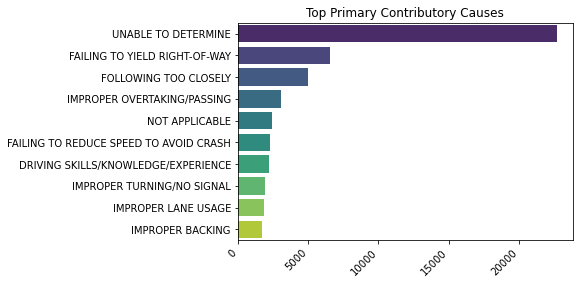

In [177]:
#Determining the top causes of crashes
top_10_crash_causes = top_causes = crashes["PRIM_CONTRIBUTORY_CAUSE"].value_counts().head(10)

sns.barplot(x=top_causes.values, y=top_causes.index, palette="viridis")
plt.title("Top Primary Contributory Causes")
plt.xticks(rotation=45, ha="right")
plt.show()

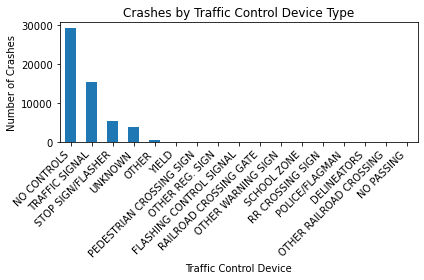

In [178]:
#Crashes by availablility of Traffic Control Devices
plt.figure()
crashes["TRAFFIC_CONTROL_DEVICE"].value_counts().plot(kind="bar")
plt.title("Crashes by Traffic Control Device Type")
plt.xlabel("Traffic Control Device")
plt.ylabel("Number of Crashes")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


A high number of accidents occured in areas with no controls(road signs, speed limits, pedestrian crossing etc.)

In [179]:
people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120061 entries, 0 to 120060
Data columns (total 29 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   PERSON_ID              120061 non-null  object 
 1   PERSON_TYPE            120061 non-null  object 
 2   CRASH_RECORD_ID        120061 non-null  object 
 3   VEHICLE_ID             116677 non-null  float64
 4   CRASH_DATE             120061 non-null  object 
 5   SEAT_NO                23368 non-null   float64
 6   CITY                   87732 non-null   object 
 7   STATE                  89192 non-null   object 
 8   ZIPCODE                83249 non-null   object 
 9   SEX                    117848 non-null  object 
 10  AGE                    86279 non-null   float64
 11  DRIVERS_LICENSE_STATE  71646 non-null   object 
 12  DRIVERS_LICENSE_CLASS  56520 non-null   object 
 13  SAFETY_EQUIPMENT       119761 non-null  object 
 14  AIRBAG_DEPLOYED        116809 non-nu

In [180]:
people.duplicated().sum()

0

In [181]:
people.isna().sum()

PERSON_ID                     0
PERSON_TYPE                   0
CRASH_RECORD_ID               0
VEHICLE_ID                 3384
CRASH_DATE                    0
SEAT_NO                   96693
CITY                      32329
STATE                     30869
ZIPCODE                   36812
SEX                        2213
AGE                       33782
DRIVERS_LICENSE_STATE     48415
DRIVERS_LICENSE_CLASS     63541
SAFETY_EQUIPMENT            300
AIRBAG_DEPLOYED            3252
EJECTION                   1738
INJURY_CLASSIFICATION        13
HOSPITAL                 105315
EMS_AGENCY               111164
EMS_RUN_NO               118551
DRIVER_ACTION             23580
DRIVER_VISION             23627
PHYSICAL_CONDITION        23513
PEDPEDAL_ACTION          116736
PEDPEDAL_VISIBILITY      116743
PEDPEDAL_LOCATION        116738
BAC_RESULT                23615
BAC_RESULT VALUE         119954
CELL_PHONE_USE           120059
dtype: int64

In [182]:
people["PHYSICAL_CONDITION"].value_counts()

NORMAL                          58425
UNKNOWN                         36085
EMOTIONAL                         604
IMPAIRED - ALCOHOL                382
REMOVED BY EMS                    342
OTHER                             253
FATIGUED/ASLEEP                   241
ILLNESS/FAINTED                    88
HAD BEEN DRINKING                  50
IMPAIRED - ALCOHOL AND DRUGS       38
IMPAIRED - DRUGS                   28
MEDICATED                          12
Name: PHYSICAL_CONDITION, dtype: int64

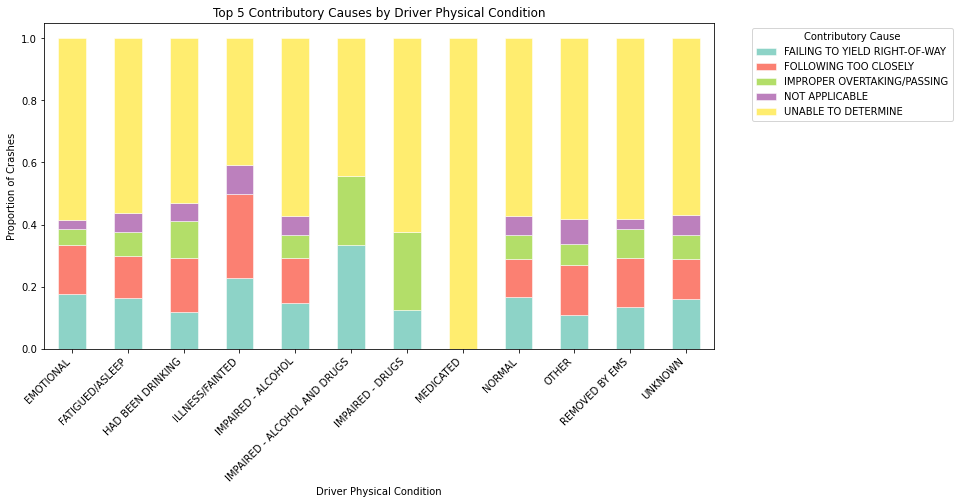

In [183]:
#Determining top causes for accidents by driver condition
top_causes = crashes["PRIM_CONTRIBUTORY_CAUSE"].value_counts().head(5).index

df_top = crashes[crashes["PRIM_CONTRIBUTORY_CAUSE"].isin(top_causes)]

ct_top = pd.crosstab(
    people["PHYSICAL_CONDITION"],
    df_top["PRIM_CONTRIBUTORY_CAUSE"],
    normalize="index"
)


plt.figure(figsize=(12, 6))
ct_top.plot(kind="bar", stacked=True, ax=plt.gca(), colormap='Set3', edgecolor='white', linewidth=0.5)
plt.title("Top 5 Contributory Causes by Driver Physical Condition")
plt.ylabel("Proportion of Crashes")
plt.xlabel("Driver Physical Condition")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Contributory Cause',bbox_to_anchor=(1.05, 1),loc='upper left')
plt.show()

In [184]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111727 entries, 0 to 111726
Data columns (total 71 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   CRASH_UNIT_ID             111727 non-null  int64  
 1   CRASH_RECORD_ID           111727 non-null  object 
 2   CRASH_DATE                111727 non-null  object 
 3   UNIT_NO                   111727 non-null  int64  
 4   UNIT_TYPE                 111651 non-null  object 
 5   NUM_PASSENGERS            16020 non-null   float64
 6   VEHICLE_ID                108262 non-null  float64
 7   CMRC_VEH_I                2030 non-null    object 
 8   MAKE                      108262 non-null  object 
 9   MODEL                     108262 non-null  object 
 10  LIC_PLATE_STATE           98787 non-null   object 
 11  VEHICLE_YEAR              93284 non-null   float64
 12  VEHICLE_DEFECT            108262 non-null  object 
 13  VEHICLE_TYPE              108262 non-null  o

## Data Cleaning and Preprocessing

In [185]:
#Columns to be used in analysis
crashes_cols = crashes[["CRASH_RECORD_ID", "CRASH_DATE", "POSTED_SPEED_LIMIT", "TRAFFIC_CONTROL_DEVICE", "WEATHER_CONDITION", "LIGHTING_CONDITION", "ROAD_DEFECT", "PRIM_CONTRIBUTORY_CAUSE","ROADWAY_SURFACE_COND"]]

## Feature Engineering

In [186]:
drivers = people[people["PERSON_TYPE"] == "DRIVER"].copy()

drivers["ALCOHOL_POSITIVE"] = drivers["BAC_RESULT VALUE"] > 0

drivers["FATIGUED"] = drivers["PHYSICAL_CONDITION"] == "FATIGUED/ASLEEP"
drivers["DRUG_IMPAIRED"] = drivers["PHYSICAL_CONDITION"] == "IMPAIRED - DRUGS"
drivers["ALCOHOL_IMPAIRED"] = drivers["PHYSICAL_CONDITION"] == "IMPAIRED - ALCOHOL"



In [187]:
drivers = people[people["PERSON_TYPE"] == "DRIVER"]

people_agg = drivers.groupby("CRASH_RECORD_ID").agg(
    AVG_DRIVER_AGE=("AGE", "mean"),
).reset_index()


In [188]:
vehicles_agg = vehicles.groupby("CRASH_RECORD_ID").agg(
    NUM_OF_VEHICLES=("CRASH_UNIT_ID", "count")
).reset_index()


In [189]:
#Merging the datasets
df = (
    crashes_cols
    .merge(people_agg, on="CRASH_RECORD_ID", how="inner")
    .merge(vehicles_agg, on="CRASH_RECORD_ID", how="inner")
)



## Data Cleaning and Preprocessing for the Merged Dataset

In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54719 entries, 0 to 54718
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CRASH_RECORD_ID          54719 non-null  object 
 1   CRASH_DATE               54719 non-null  object 
 2   POSTED_SPEED_LIMIT       54719 non-null  int64  
 3   TRAFFIC_CONTROL_DEVICE   54719 non-null  object 
 4   WEATHER_CONDITION        54719 non-null  object 
 5   LIGHTING_CONDITION       54719 non-null  object 
 6   ROAD_DEFECT              54719 non-null  object 
 7   PRIM_CONTRIBUTORY_CAUSE  54719 non-null  object 
 8   ROADWAY_SURFACE_COND     54719 non-null  object 
 9   AVG_DRIVER_AGE           44142 non-null  float64
 10  NUM_OF_VEHICLES          54719 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 5.0+ MB


In [191]:
df.shape

(54719, 11)

In [192]:
#Cleaning the merged dataset
df.isna().sum()

CRASH_RECORD_ID                0
CRASH_DATE                     0
POSTED_SPEED_LIMIT             0
TRAFFIC_CONTROL_DEVICE         0
WEATHER_CONDITION              0
LIGHTING_CONDITION             0
ROAD_DEFECT                    0
PRIM_CONTRIBUTORY_CAUSE        0
ROADWAY_SURFACE_COND           0
AVG_DRIVER_AGE             10577
NUM_OF_VEHICLES                0
dtype: int64

In [193]:
df["AVG_DRIVER_AGE"] = df["AVG_DRIVER_AGE"].fillna(
    df["AVG_DRIVER_AGE"].median()
)


In [194]:
df.isna().sum()

CRASH_RECORD_ID            0
CRASH_DATE                 0
POSTED_SPEED_LIMIT         0
TRAFFIC_CONTROL_DEVICE     0
WEATHER_CONDITION          0
LIGHTING_CONDITION         0
ROAD_DEFECT                0
PRIM_CONTRIBUTORY_CAUSE    0
ROADWAY_SURFACE_COND       0
AVG_DRIVER_AGE             0
NUM_OF_VEHICLES            0
dtype: int64

In [195]:
df.duplicated().sum()

0

In [196]:
df["PRIM_CONTRIBUTORY_CAUSE"].value_counts()

UNABLE TO DETERMINE                                                                 22582
FAILING TO YIELD RIGHT-OF-WAY                                                        6507
FOLLOWING TOO CLOSELY                                                                4988
IMPROPER OVERTAKING/PASSING                                                          3032
NOT APPLICABLE                                                                       2418
FAILING TO REDUCE SPEED TO AVOID CRASH                                               2263
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE                                                  2176
IMPROPER TURNING/NO SIGNAL                                                           1898
IMPROPER LANE USAGE                                                                  1832
IMPROPER BACKING                                                                     1703
DISREGARDING TRAFFIC SIGNALS                                                         1039
WEATHER   

In [197]:
#Combining the primary causes into new categories
cause_map = {
    "FAILING TO YIELD RIGHT-OF-WAY": "DRIVER_ERROR/NEGLIGENCE",
    "FOLLOWING TOO CLOSELY": "DRIVER_ERROR/NEGLIGENCE",
    "IMPROPER OVERTAKING/PASSING": "DRIVER_ERROR/NEGLIGENCE",
    "NOT APPLICABLE" : "OTHER",
    "FAILING TO REDUCE SPEED TO AVOID CRASH": "SPEEDING",
    "DRIVING SKILLS/KNOWLEDGE/EXPERIENCE": "DRIVER_ERROR/NEGLIGENCE",
    "IMPROPER TURNING/NO SIGNAL": "DRIVER_ERROR/NEGLIGENCE",
    "IMPROPER LANE USAGE": "DRIVER_ERROR/NEGLIGENCE",
    "IMPROPER BACKING": "DRIVER_ERROR/NEGLIGENCE", 
    "DISREGARDING TRAFFIC SIGNALS": "DRIVER_ERROR/NEGLIGENCE",
    "WEATHER": "WEATHER",
    "OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER": "DRIVER_ERROR/NEGLIGENCE",
    "DISREGARDING STOP SIGN": "DRIVER_ERROR/NEGLIGENCE",
    "DRIVING ON WRONG SIDE/WRONG WAY": "DRIVER_ERROR/NEGLIGENCE",
    "DISTRACTION - FROM INSIDE VEHICLE": "DISTRACTION",
    "VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)":"OBSCURED VISION",
    "PHYSICAL CONDITION OF DRIVER": "DRIVER_CONDITION",
    "UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)": "ALCOHOL/DRUG_IMPAIRMENT",
    "EQUIPMENT - VEHICLE CONDITION": "VEHICLE_CONDITION",
    "DISTRACTION - FROM OUTSIDE VEHICLE": "DISTRACTION", 
    "DISREGARDING OTHER TRAFFIC SIGNS": "DRIVER_ERROR/NEGLIGENCE",
    "EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST": "EVASIVE_ACTION",
    "DISREGARDING ROAD MARKINGS": "DRIVER_ERROR/NEGLIGENCE",
    "ROAD CONSTRUCTION/MAINTENANCE": "ROAD_WORK",
    "ROAD ENGINEERING/SURFACE/MARKING DEFECTS": "POOR_ROAD_CONDITION",
    "CELLPHONE USE OTHER THAN TEXTING": "MOBILE_PHONE_USE",
    "ANIMAL": "EVASIVE_ACTION",
    "TURNING RIGHT ON RED": "DRIVER_ERROR/NEGLIGENCE", 
    "RELATED TO BUS STOP": "OTHER",
    "DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)": "DISTRACTION",
    "HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)": "ALCOHOL/DRUG_IMPAIRMENT",
    "TEXTING": "DISTRACTION",
    "OBSTRUCTED CROSSWALKS": "POOR_ROAD_CONDITION",
    "PASSING STOPPED SCHOOL BUS": "DRIVER_ERROR/NEGLIGENCE",
    "DISREGARDING YIELD SIGN": "DRIVER_ERROR/NEGLIGENCE",
    "BICYCLE_ADVANCING LEGALLY ON RED LIGHT": "OTHER",
    "MOTORCYCLE_ADVANCING LEGALLY ON RED LIGHT": "OTHER",
    "UNABLE TO DETERMINE": "OTHER"
    
}


In [198]:
df["CAUSE_GROUPED"] = df["PRIM_CONTRIBUTORY_CAUSE"].map(cause_map)
df["CAUSE_GROUPED"] = df["CAUSE_GROUPED"].fillna("OTHER")



In [199]:
#Minimising categories in TRAFFIC CONTROL DEVICE column
control_device_map = {
    "NO CONTROLS": "NO_CONTROLS",
    "TRAFFIC SIGNAL": "CONTROLS_PRESENT",
    "STOP SIGN/FLASHER": "CONTROLS_PRESENT",           
    "UNKNOWN ": "CONTROLS_PRESENT",                    
    "OTHER": "CONTROLS_PRESENT",                          
    "YIELD": "CONTROLS_PRESENT",                          
    "PEDESTRIAN CROSSING SIGN": "CONTROLS_PRESENT",     
    "OTHER REG. SIGN": "CONTROLS_PRESENT",               
    "FLASHING CONTROL SIGNAL": "CONTROLS_PRESENT", 
    "RAILROAD CROSSING GATE": "CONTROLS_PRESENT", 
    "OTHER WARNING SIGN": "CONTROLS_PRESENT",              
    "SCHOOL ZONE": "CONTROLS_PRESENT",                     
    "RR CROSSING SIGN": "CONTROLS_PRESENT",                
    "POLICE/FLAGMAN": "CONTROLS_PRESENT",                  
    "OTHER RAILROAD CROSSING": "CONTROLS_PRESENT",         
    "DELINEATORS": "CONTROLS_PRESENT",                     
    "NO PASSING": "NO_CONTROLS"
    
}

In [200]:
df["WEATHER_CONDITION"].value_counts()

CLEAR                       43903
UNKNOWN                      4510
RAIN                         2810
SNOW                         1747
CLOUDY/OVERCAST              1375
OTHER                         196
FREEZING RAIN/DRIZZLE          74
BLOWING SNOW                   41
SLEET/HAIL                     38
FOG/SMOKE/HAZE                 22
SEVERE CROSS WIND GATE          2
BLOWING SAND, SOIL, DIRT        1
Name: WEATHER_CONDITION, dtype: int64

In [201]:
df["TRAFFIC_CONTROL_DEVICE_AVAILABILITY"] =df["TRAFFIC_CONTROL_DEVICE"].map(control_device_map) 

In [202]:
df["TRAFFIC_CONTROL_DEVICE_AVAILABILITY"] = df["TRAFFIC_CONTROL_DEVICE_AVAILABILITY"].fillna("UNKNOWN")

In [203]:
#Dropping the PRIM_CONTRIBUTORY_CAUSE_COLUMN and TRAFFIC CONTROL DEVICE column
df = df.drop(columns=["PRIM_CONTRIBUTORY_CAUSE", "TRAFFIC_CONTROL_DEVICE"], axis=1)

In [204]:
df["CRASH_DATE"] = pd.to_datetime(df["CRASH_DATE"])

In [205]:
df["DAY_OF_WEEK"] = df["CRASH_DATE"].dt.dayofweek
#Monday-0, Tuesday-1,...,Sunday-6
df["MONTH"] = df["CRASH_DATE"].dt.month


In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54719 entries, 0 to 54718
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   CRASH_RECORD_ID                      54719 non-null  object        
 1   CRASH_DATE                           54719 non-null  datetime64[ns]
 2   POSTED_SPEED_LIMIT                   54719 non-null  int64         
 3   WEATHER_CONDITION                    54719 non-null  object        
 4   LIGHTING_CONDITION                   54719 non-null  object        
 5   ROAD_DEFECT                          54719 non-null  object        
 6   ROADWAY_SURFACE_COND                 54719 non-null  object        
 7   AVG_DRIVER_AGE                       54719 non-null  float64       
 8   NUM_OF_VEHICLES                      54719 non-null  int64         
 9   CAUSE_GROUPED                        54719 non-null  object        
 10  TRAFFIC_CO

In [207]:
#converting data types
df["AVG_DRIVER_AGE"] =  df["AVG_DRIVER_AGE"].astype(int)

In [208]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54719 entries, 0 to 54718
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   CRASH_RECORD_ID                      54719 non-null  object        
 1   CRASH_DATE                           54719 non-null  datetime64[ns]
 2   POSTED_SPEED_LIMIT                   54719 non-null  int64         
 3   WEATHER_CONDITION                    54719 non-null  object        
 4   LIGHTING_CONDITION                   54719 non-null  object        
 5   ROAD_DEFECT                          54719 non-null  object        
 6   ROADWAY_SURFACE_COND                 54719 non-null  object        
 7   AVG_DRIVER_AGE                       54719 non-null  int32         
 8   NUM_OF_VEHICLES                      54719 non-null  int64         
 9   CAUSE_GROUPED                        54719 non-null  object        
 10  TRAFFIC_CO

In [209]:
#Encoding categorical variables
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
X_cat = df[["WEATHER_CONDITION", "LIGHTING_CONDITION", "ROAD_DEFECT", "ROADWAY_SURFACE_COND", "TRAFFIC_CONTROL_DEVICE_AVAILABILITY"]]
X_cat_ohe = ohe.fit_transform(X_cat)

In [210]:
#Concatanating categorical with other columns
X_cat_df = pd.DataFrame(
    X_cat_ohe,
    columns=ohe.get_feature_names(X_cat.columns),
    index=X_cat.index
)

X_final = pd.concat([df[["POSTED_SPEED_LIMIT", "AVG_DRIVER_AGE", "NUM_OF_VEHICLES", "DAY_OF_WEEK", "MONTH"]],X_cat_df],axis=1)


In [211]:
X_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54719 entries, 0 to 54718
Data columns (total 40 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   POSTED_SPEED_LIMIT                                    54719 non-null  int64  
 1   AVG_DRIVER_AGE                                        54719 non-null  int32  
 2   NUM_OF_VEHICLES                                       54719 non-null  int64  
 3   DAY_OF_WEEK                                           54719 non-null  int64  
 4   MONTH                                                 54719 non-null  int64  
 5   WEATHER_CONDITION_BLOWING SAND, SOIL, DIRT            54719 non-null  float64
 6   WEATHER_CONDITION_BLOWING SNOW                        54719 non-null  float64
 7   WEATHER_CONDITION_CLEAR                               54719 non-null  float64
 8   WEATHER_CONDITION_CLOUDY/OVERCAST                     54

In [212]:
#Label encoding the target and defining X and y
lab_enc = LabelEncoder()
X = X_final
y = lab_enc.fit_transform(df["CAUSE_GROUPED"])


## **Modelling**

In [213]:
#Splitting data into train and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [214]:
#Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Baseline Model

In [215]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
])

#Fitting the pipeline
pipeline.fit(X_train, y_train)        
y_pred = pipeline.predict(X_test)


In [220]:
print(classification_report(y_test, y_pred), accuracy_score(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.12      0.02      0.04        87
           1       0.02      0.01      0.01       147
           2       0.03      0.01      0.02        86
           3       0.53      0.57      0.55      7421
           4       0.00      0.00      0.00        42
           5       0.00      0.00      0.00        79
           6       0.55      0.58      0.56      7580
           7       0.14      0.05      0.07        22
           8       0.17      0.06      0.09        17
           9       0.07      0.03      0.04       667
          10       0.00      0.00      0.00        76
          11       0.26      0.16      0.20       192

    accuracy                           0.53     16416
   macro avg       0.16      0.12      0.13     16416
weighted avg       0.50      0.53      0.52     16416
 0.5280214424951267


In [218]:
#GridsearchCV
